In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_daily_data(file, skiprows, colname):
    df = pd.read_csv(file, skiprows=skiprows, sep='\t').iloc[1:,]
    df.index = pd.to_datetime(df['datetime'])
    df = pd.to_numeric(df[colname])
    df_agg = df.resample('D').mean()
    return df_agg
    
### look at data for cannonsville reservoir
up1 = get_daily_data('input_data/usgs_gages/usgs_01413500_e_b_delaware_r_at_margaretville_ny.txt', 31, '107251_00060')
up2 = get_daily_data('input_data/usgs_gages/usgs_01414000_platte_k_at_dunraven_ny.txt', 31, '107256_00060')
down = get_daily_data('input_data/usgs_gages/usgs_01417000_e_b_delaware_r_at_downsville_ny.txt', 29, '107268_00060')

### set all to smallest date range (up2), and replace nans with 0
up1 = up1.loc[up2.index]
down = down.loc[up2.index]
up1.loc[np.isnan(up1)] = 0.0
up2.loc[np.isnan(up2)] = 0.0
down.loc[np.isnan(down)] = 0.0


### convert cfs to mgd
up1 *= 0.0283 * 22824465.32 / 1e6
up2 *= 0.0283 * 22824465.32 / 1e6
down *= 0.0283 * 22824465.32 / 1e6

### specify daily demand (fixed for now)
demand = (up1 + up2 - down).mean()

print(up1)
print(up2)
print(down)

/tmp/ipykernel_2457/2486045471.py:2: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, skiprows=skiprows, sep='\t').iloc[1:,]
/tmp/ipykernel_2457/2486045471.py:2: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, skiprows=skiprows, sep='\t').iloc[1:,]
/tmp/ipykernel_2457/2486045471.py:2: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, skiprows=skiprows, sep='\t').iloc[1:,]


datetime
1996-12-05      0.000000
1996-12-06      0.000000
1996-12-07      0.000000
1996-12-08      0.000000
1996-12-09      0.000000
                 ...    
2021-12-27    219.092185
2021-12-28    214.711956
2021-12-29    224.824835
2021-12-30    232.892261
2021-12-31    242.042970
Freq: D, Name: 107251_00060, Length: 9158, dtype: float64
datetime
1996-12-05    135.208447
1996-12-06    115.823748
1996-12-07     86.682778
1996-12-08     72.337697
1996-12-09     59.990969
                 ...    
2021-12-27     44.206669
2021-12-28     46.666595
2021-12-29     48.921303
2021-12-30     48.854018
2021-12-31     49.277238
Freq: D, Name: 107256_00060, Length: 9158, dtype: float64
datetime
1996-12-05    1824.086095
1996-12-06    1526.284359
1996-12-07    1236.556778
1996-12-08    1049.370960
1996-12-09     896.029308
                 ...     
2021-12-27     172.342830
2021-12-28     172.262089
2021-12-29     171.979493
2021-12-30     171.979493
2021-12-31     171.818010
Freq: D, Name: 107268

0.8728786518955028
0.5480746537405691
-1.4210854715202004e-14


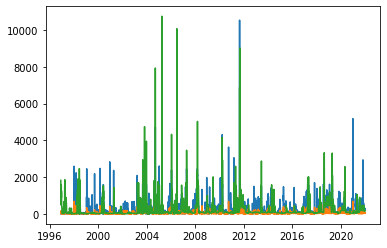

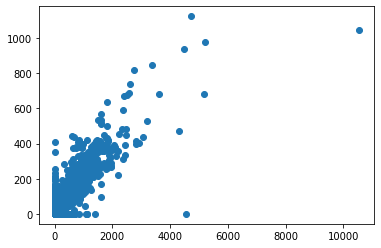

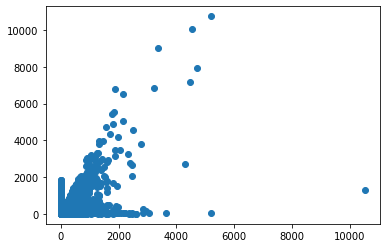

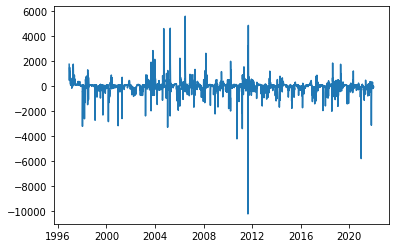

In [3]:
plt.figure()
plt.plot(up1)
plt.plot(up2)
plt.plot(down)

plt.figure()
plt.scatter(up1, up2)
print(np.corrcoef(up1, up2)[0,1])

plt.figure()
plt.scatter(up1, down)
print(np.corrcoef(up1, down)[0,1])

plt.figure()
plt.plot(down - up1 - up2 + demand)

print(down.mean() - (up1 + up2).mean() + demand)

[2.48848717]


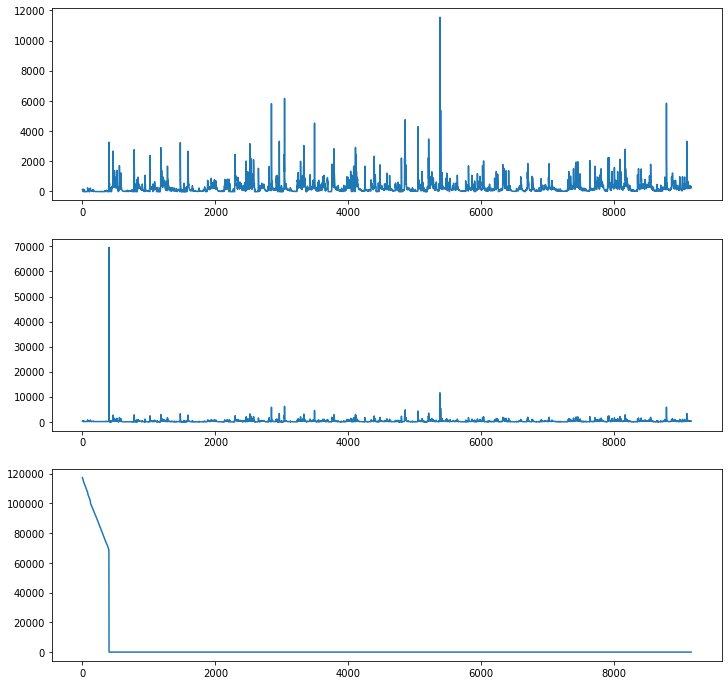

In [4]:
storage_max = 146641.8772      ## MG, from GRanD
storage_init = 0.8 * storage_max
    
### build function for simulating reservoir release
def release_func(storage, inflow, params):
    ### assume for now quadratic function of storage & inflow, 6 params
    a,b,c,d,e,f = params
    release = a * storage **2 + b * inflow **2 + c * storage + d * inflow + e * storage * inflow + f
    release = max(release, 0)
    return release

### function for simulating system, given resevoir release_func & inflow timeseries
def simulate_reservoir(inflows, release_func, params):
    storages = np.zeros(len(inflows) + 1)
    storages[0] = storage_init
    releases = np.zeros(len(inflows))
    for t, inflow in enumerate(inflows):
        releases[t] = release_func(storages[t], inflow, params)
        storages[t+1] = storages[t] + inflow  - releases[t]
        if storages[t+1] < 0:
            releases[t] += storages[t+1]
            storages[t+1] = 0
        elif storages[t+1] > storage_max:
            releases[t] += storages[t+1] - storage_max
            storages[t+1] = storage_max
    return releases, storages


### evaluate fit with NSE
def nse(predictions, targets):
    return (1-(np.sum((predictions-targets)**2)/np.sum((targets-np.mean(targets))**2)))

### build function for evaluating fit of particular param set
def test_release_func(x, inflows, outflows, plot=True):
    ### x should be an array, each row is a particle to be evaluated, each column is different param

    costs = []
    for i in range(x.shape[0]):
        params = x[i,:]
        releases, storages = simulate_reservoir(inflows, release_func, params)

        if plot:
            fig, axs = plt.subplots(3, figsize = (12,12))
            axs[0].plot(inflows)
            axs[1].plot(releases)
            axs[2].plot(storages)


        ### return -nse as cost that we want to minimize
        costs.append(-nse(releases, outflows))
        
    return np.array(costs)

### run test
inflows = np.array(up1 + up2 - demand)
outflows = np.array(down)
params = np.array([[0,0.01,0,0.8,0,100]])
costs = test_release_func(params, inflows, outflows)
print(costs)

In [5]:
# ### now optimize rule curve with particle swarm optimization
# import pyswarms as ps

# # Set-up hyperparameters
# options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

# # Call instance of PSO
# optimizer = ps.single.GlobalBestPSO(n_particles=20, dimensions=6, options=options)

# # Perform optimization
# cost_opt, params_opt = optimizer.optimize(test_release_func, iters=100, inflows=inflows, outflows=outflows, plot=False)

In [6]:
# costs = test_release_func(np.array([pos]), inflows, outflows)
# releases, storages = simulate_reservoir(inflows, release_func, params_opt)

# fig, axs = plt.subplots(1,2, figsize=(14,6))
# axs[0].scatter(outflows, inflows)
# axs[1].scatter(outflows, releases)


In [7]:
### above looks pretty bad, may be due to form of parameterized rule, or PSO insufficient. Try using random forest.
### first build predictor dataset based on inflow, storage, cos(t), sin(t), reconstruct storages using observed inflow/outflow
storages = [storage_init]
T = len(inflows)
for t in range(T):
    storages.append(max(storages[t] + inflows[t] - outflows[t], 0))
storages = np.array(storages)
cos_t = np.cos(np.arange(len(inflows)) * 2 * np.pi / 365)
sin_t = np.sin(np.arange(len(inflows)) * 2 * np.pi / 365)

X = np.empty((T, 4))
X[:,0] = inflows
X[:,1] = storages[:-1]
X[:,2] = cos_t
X[:,3] = sin_t

In [8]:
### now build random forest
from sklearn.ensemble import RandomForestRegressor as rfr
regressor = rfr(n_estimators = 10, random_state = 0)
regressor.fit(X, outflows)

RandomForestRegressor(n_estimators=10, random_state=0)

0.5542372965159472
0.9583138765576739


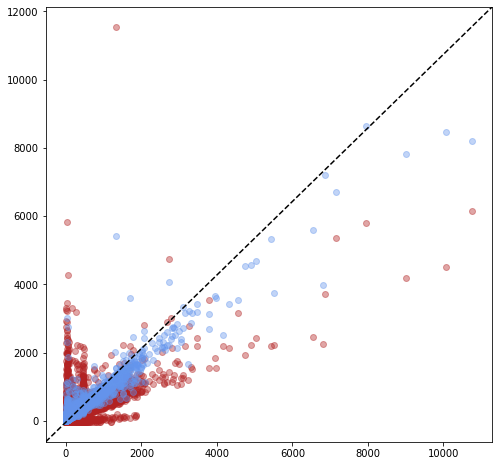

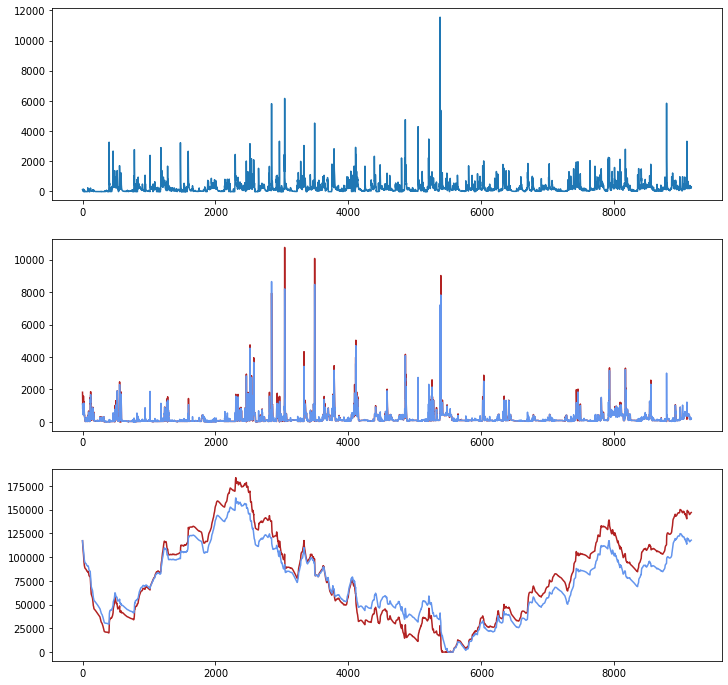

In [9]:
outflows_predicted = regressor.predict(X)
storages_predicted = [storage_init]
for t in range(T):
    storages_predicted.append(max(storages_predicted[t] + inflows[t] - outflows_predicted[t], 0))
storages_predicted = np.array(storages_predicted)

fig, ax = plt.subplots(1,figsize=(8,8))
ax.scatter(outflows, inflows, alpha=0.4, color='firebrick')
ax.scatter(outflows, outflows_predicted, alpha=0.4, color='cornflowerblue')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='k', ls='--', zorder=1)

print(np.corrcoef(inflows, outflows)[0,1])
print(np.corrcoef(outflows, outflows_predicted)[0,1])

fig, axs = plt.subplots(3, figsize = (12,12))
axs[0].plot(inflows)
axs[1].plot(outflows, color='firebrick')
axs[1].plot(outflows_predicted, color='cornflowerblue')
axs[2].plot(storages, color='firebrick')
axs[2].plot(storages_predicted, color='cornflowerblue')

59602.00367174756
0.49107993597114236
0.47083167826568845


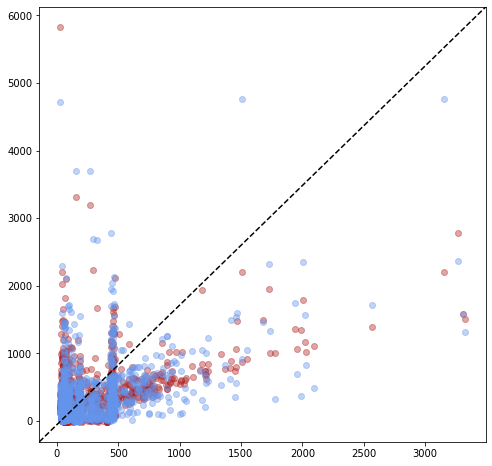

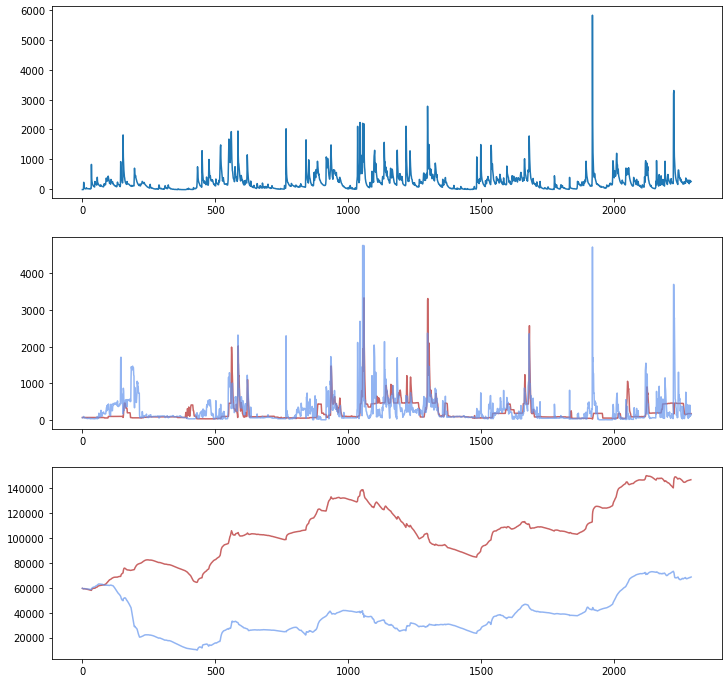

In [10]:
### try again with train/test set
T_train = int(3*T/4)
T_test = T - T_train

X_train, X_test = X[:T_train, :], X[T_train:, :]
inflows_train, storages_train = X_train[:, 0], X_train[:, 1]
inflows_test, storages_test = X_test[:, 0], X_test[:, 1]
outflows_train, outflows_test = outflows[:T_train], outflows[T_train:]

regressor = rfr(n_estimators = 10, random_state = 0)
regressor.fit(X_train, outflows_train)

outflows_predicted = regressor.predict(X_test)
print(storages[T_train-1])
storages_predicted = [storages[T_train-1]]
# storages_test = [storage_init]
for t in range(T_test):
    storages_predicted.append(storages_predicted[t] + inflows_test[t] - outflows_predicted[t])
    if storages_predicted[t+1] < 0:
        outflows_predicted[t] += storages_predicted[t+1]
        storages_predicted[t+1] = 0
    elif storages_predicted[t+1] > storage_max:
        outflows_predicted[t+1] -= storage_max - storages_predicted[t+1]
        storages_predicted[t+1] = storage_max
#     storages_test.append(storages_test[t] + inflows_test[t] - outflows_test[t])
    
storages_predicted = np.array(storages_predicted)

fig, ax = plt.subplots(1,figsize=(8,8))
ax.scatter(outflows_test, inflows_test, alpha=0.4, color='firebrick')
ax.scatter(outflows_test, outflows_predicted, alpha=0.4, color='cornflowerblue')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='k', ls='--', zorder=1)

print(np.corrcoef(inflows_test, outflows_test)[0,1])
print(np.corrcoef(outflows_test, outflows_predicted)[0,1])

fig, axs = plt.subplots(3, figsize = (12,12))
axs[0].plot(inflows_test)
axs[1].plot(outflows_test, color='firebrick', alpha=0.7)
axs[1].plot(outflows_predicted, color='cornflowerblue', alpha=0.7)
axs[2].plot(storages_test, color='firebrick', alpha=0.7)
axs[2].plot(storages_predicted, color='cornflowerblue', alpha=0.7)

### try beltzville, starfit reservoir. some of difficulty above likely due to variable demand from cannonsville

/tmp/ipykernel_2457/320580324.py:2: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, skiprows=skiprows, sep='\t').iloc[1:,]
/tmp/ipykernel_2457/320580324.py:2: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, skiprows=skiprows, sep='\t').iloc[1:,]


0.6781951622066666
-49.418632965792995


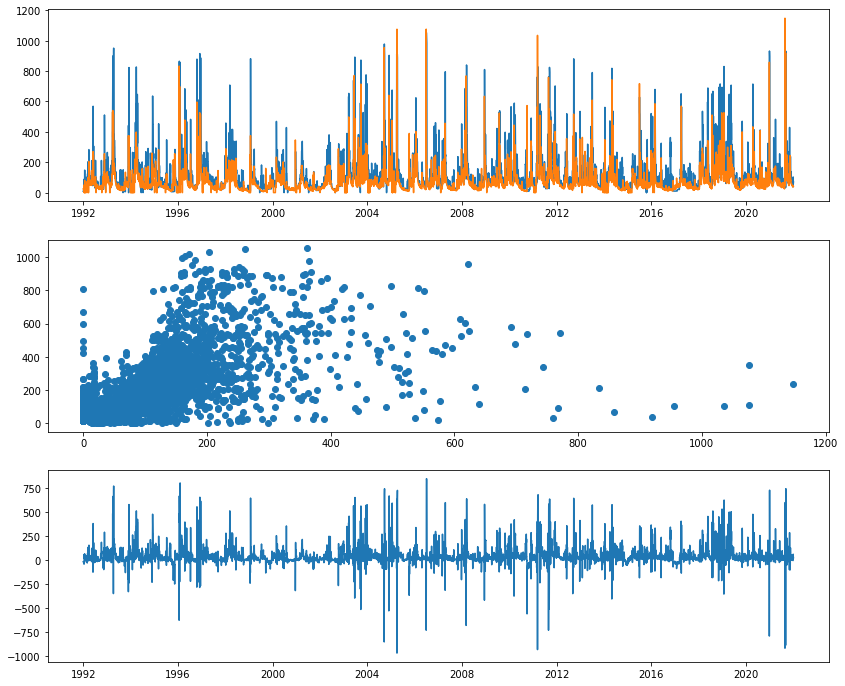

In [11]:
def get_daily_data(file, skiprows, colname):
    df = pd.read_csv(file, skiprows=skiprows, sep='\t').iloc[1:,]
    df.index = pd.to_datetime(df['datetime'])
    df = pd.to_numeric(df[colname])
    df_agg = df.resample('D').mean()
    return df_agg
    
### look at data for cannonsville reservoir
up = get_daily_data('input_data/usgs_gages/usgs_01449360_pohopoco_c_at_kresgeville_pa.txt', 31, '121251_00060')
down = get_daily_data('input_data/usgs_gages/usgs_01449800_pohopoco_cr_bl_beltzville_dam_nr_parryville_pa.txt', 30, '121259_00060')

### set all to smallest date range, and replace nans with 0
up = up.loc[down.index]
up = up.loc[up.index.year > 1991]
down = down.loc[down.index.year > 1991]
up.loc[np.isnan(up)] = 0.0
down.loc[np.isnan(down)] = 0.0


### convert cfs to mgd
up *= 0.0283 * 22824465.32 / 1e6
down *= 0.0283 * 22824465.32 / 1e6

fig, axs = plt.subplots(3, figsize=(14,12))
axs[0].plot(down)
axs[0].plot(up)
axs[1].scatter(up, down)
axs[2].plot(down - up)

print(np.corrcoef(up, down)[0,1])
print(up.mean() - down.mean())

0.4661552161432096


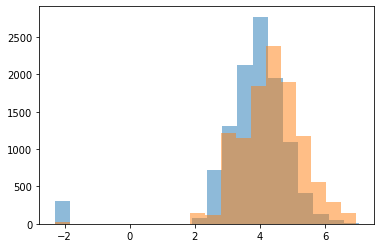

In [12]:
### take log, then fit up & down to (log)normal. 
logup = np.log(up + 0.1)
logdown = np.log(down + 0.1)
plt.hist(logup, alpha=0.5, bins=20)
plt.hist(logdown, alpha=0.5, bins=20)
print(np.corrcoef(logup, logdown)[0,1])

(array([6270., 1979.,  919.,  479.,  291.,  212.,  139.,  125.,   85.,
          82.,   49.,   39.,   36.,   24.,   29.,   22.,   15.,   17.,
          21.,    7.]),
 array([   0.        ,   57.40051079,  114.80102159,  172.20153238,
         229.60204317,  287.00255397,  344.40306476,  401.80357555,
         459.20408635,  516.60459714,  574.00510793,  631.40561873,
         688.80612952,  746.20664031,  803.60715111,  861.0076619 ,
         918.40817269,  975.80868349, 1033.20919428, 1090.60970507,
        1148.01021586]),
 <BarContainer object of 20 artists>)

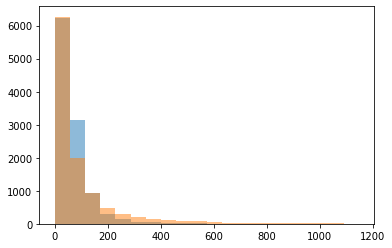

In [13]:
### fit mu/std/corr of ungaged inflows, using random forest model nested inside
from scipy.stats import norm

def draw_lognorm_x1_given_x2(x2, rho):
    logx2 = np.log(x2 + 0.01).values
    mu2, std2 = norm.fit(logx2)
    mu1, std1 = mu2, std2
    mu_conditional = mu1 + std1 / std2 * rho * (logx2 - mu2)
    std_conditional = np.sqrt((1 - rho **2) * std1 **2)
    logx1 = [norm.rvs(loc = m, scale = std_conditional, size = 1) for m in mu_conditional]
    x1 = np.exp(logx1)
    return x1

h = plt.hist(up, alpha= 0.5, bins=20)
plt.hist(draw_lognorm_x1_given_x2(up, 0.5), alpha=0.5, bins=h[1])

### lognorm seems like a bad fit, should try gamma + copula approach
### also, should first use starfit rules in inner loop rather than random forest

(array([3441., 3489., 1662.,  955.,  426.,  286.,  161.,  108.,   99.,
          63.,   72.,   33.,   38.,   24.,   16.,   37.,   22.,   16.,
           5.,    5.]),
 array([   0.        ,   52.67040189,  105.34080377,  158.01120566,
         210.68160754,  263.35200943,  316.02241132,  368.6928132 ,
         421.36321509,  474.03361697,  526.70401886,  579.37442075,
         632.04482263,  684.71522452,  737.3856264 ,  790.05602829,
         842.72643018,  895.39683206,  948.06723395, 1000.73763583,
        1053.40803772]),
 <BarContainer object of 20 artists>)

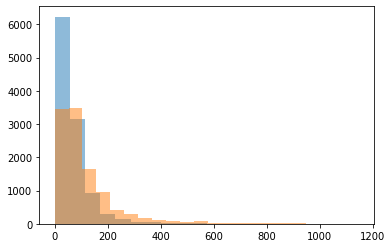

In [14]:
plt.hist(up, alpha=0.5, bins=20)
plt.hist(down, alpha=0.5, bins=20)